##  Time Series Temperature Forecasting Using ARIMA & Forecasting Models

Accurate temperature forecasting is vitally important for many real-world applications. Sectors like agriculture and energy rely on temperature predictions to make informed decisions. For example, farmers depend on weather forecasts (especially temperature and precipitation) to plan planting, irrigation, and harvesting, as temperature directly affects crop growth and yields).

### **Project Objectives:**
The aim of this project is to develop and compare different time series models for daily temperature data and determine which model provides the most accurate short and long-term forecast. We focus on univariate time series forecasting (using only past temperatures). 
By evaluating a range of models from simple benchmarks to more complex models, we can identify which modeling approach best captures the trend and seasonal structure of the data for year-ahead prediction. The ultimate objective is to produce a reliable forecast for the next 365 days and recommend the best-performing model for practical use.

### Industries & Use Cases where Time Series plays significant Role:
Agriculture: Farmers plan irrigation, sowing, harvesting
Retail: Seasonal product planning (ACs, fans, winter gear)
Energy: Demand forecasting (power, heating, cooling)
Supply Chain: Cold chain logistics for food/pharma

## Data Exploration: 

We will use the Publicly available kaggle dataset. The dataset consists of daily minimum temperature observations collected by the (available via Kaggle). It spans roughly 10 years of continuous daily data (≈4,018 days), providing a rich time series of temperature readings. The data covers a single location’s temperatures (in °C) over this period. We used the first ~9 years of data for training our models and reserved the final 1 year (365 days) for validation/testing of the forecasts. 

Data set likn: 

The dataset has a strong seasonal component with a yearly cycle: temperatures peak in the summer months and drop in winter months, as expected for the locale.

## Project Workflow / Steps

1. Data Loading & Cleaning
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing
4. Feature Engineering
5. Time Series Forecasting Models
6. Evaluation & Comparison
7. Forecasting Future Temperatures
8. Conclusion & Business Insights

In [3]:
!pip install seaborn 

In [4]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore") 


### Data Preparation and Data Cleaning: 

The initial steps involved data cleaning and preparation, where I converted the temperature column to numeric values and ensured the date column was in the correct Date format using datetime . After handling any missing values and datatypes, created a time series object starting from January 1981 with a daily frequency of 365 observations per year. This prepared dataset was then used for further analysis and forecasting

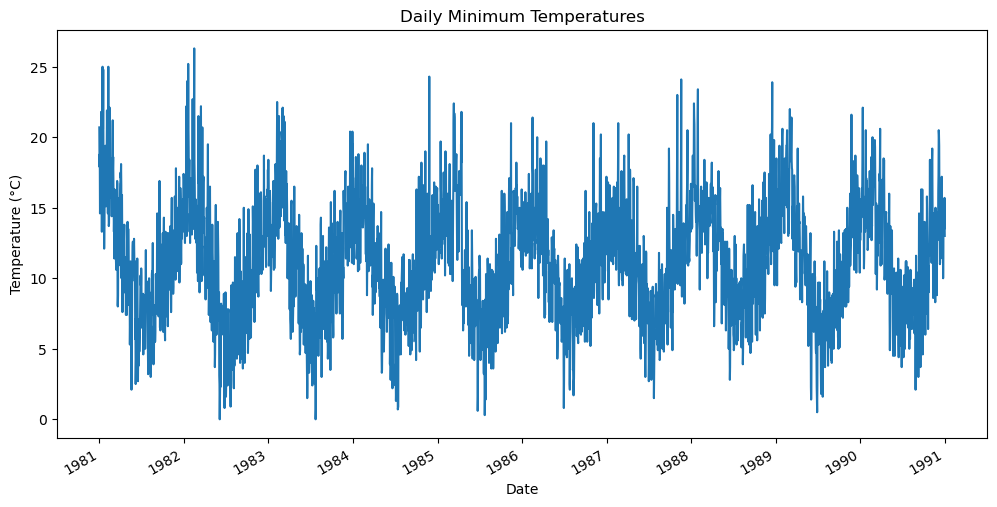

In [5]:
# Load data
df = pd.read_csv('daily-minimum-temperatures-in-me.csv')

# Convert date
df['Date'] = pd.to_datetime(df['Date'])
df['Temperature'] = pd.to_numeric(df['Daily minimum temperatures'], errors='coerce')
df.dropna(inplace=True)

# Set index
df.set_index('Date', inplace=True)

# Visualize time series
df['Temperature'].plot(figsize=(12,6), title='Daily Minimum Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show() 

The Above time series plot of daily minimum temperatures from 1981 to 1990, shows strong seasonal pattern visible with yearly cycles.
There is no clear long-term trend, but high variability across years and the amplitude of seasonal variation seems consistent. 

In [6]:
# ADF Test
adf_result = adfuller(train['Temperature'])
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")

# KPSS Test
kpss_result = kpss(train['Temperature'], regression='c')
print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")  


NameError: name 'train' is not defined

The p-value is very small (less than 0.05), so you reject the null hypothesis and The series is stationary according to the ADF test.
Both tests agree the series is stationary. (ADF rejects non-stationarity, KPSS accepts stationarity.)

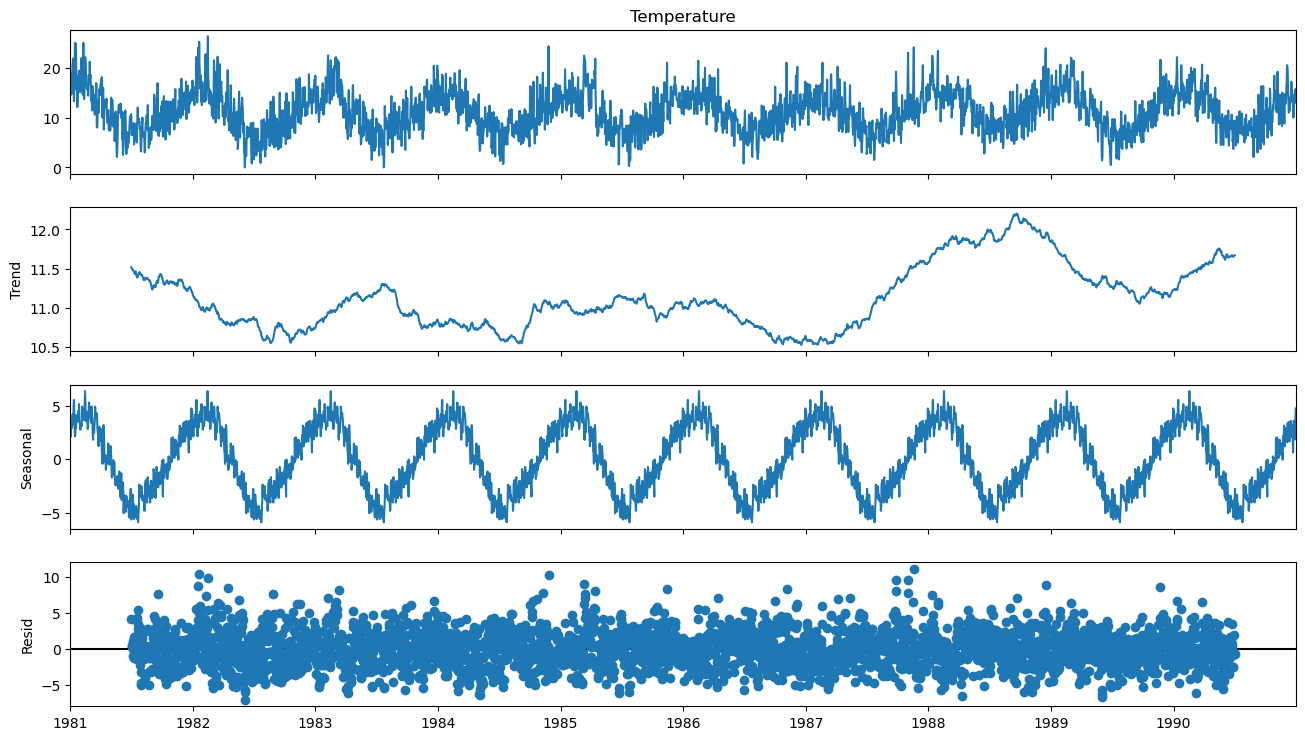

In [7]:
# Decompose time series
# Model can be 'additive' or 'multiplicative'
# Period = 365 (daily data with yearly seasonality)
decomp = seasonal_decompose(df['Temperature'], model='additive', period=365)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(14, 8)
plt.show() 


The decomposition showing:

Original data, Seasonal component, Trend component and  Remainder component and some insights require for our project.

The seasonal component is strong and consistent over time.
The trend component shows minor variations, indicating stable long-term behavior.
The remainder component (residuals) captures random noise.

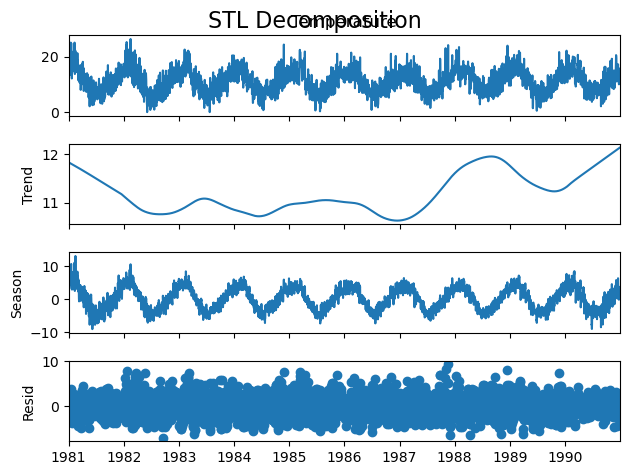

In [8]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition with yearly seasonality (period=365)
stl = STL(df['Temperature'], period=365)
stl_result = stl.fit()

# Extract components
trend = stl_result.trend
seasonal = stl_result.seasonal
residuals_stl = stl_result.resid

# Plot the STL decomposition
stl_result.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.show() 


### ACF AND PACF Autocorrelation Plots

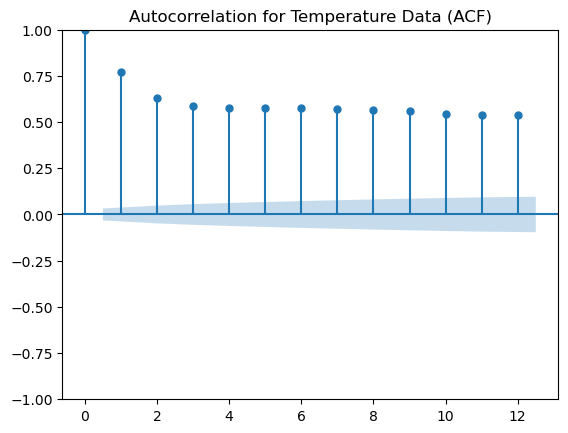

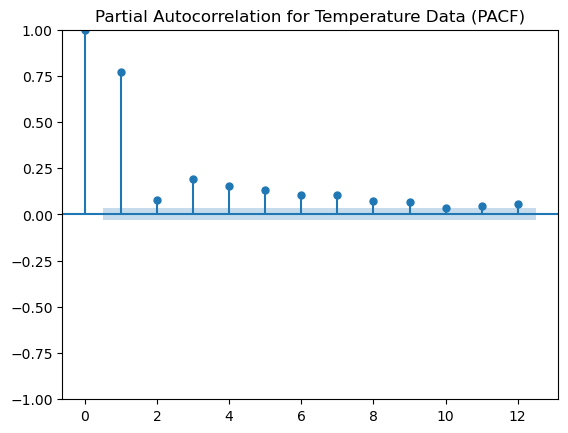

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation function (ACF)
plot_acf(df['Temperature'], lags=12)
plt.title('Autocorrelation for Temperature Data (ACF)')
plt.show()

# Partial autocorrelation function (PACF)
plot_pacf(df['Temperature'], lags=12)
plt.title('Partial Autocorrelation for Temperature Data (PACF)')
plt.show() 


To further analyze patterns, we examined the **autocorrelation function (ACF)** and **partial autocorrelation function (PACF)** of the daily temperature series.

1. From **autocorrelation function (ACF)** plot of the daily temperature series we retrived below insights.
High autocorrelation at **all lags, slowly decaying, suggesting strong seasonality and persistence in the data,** which is useful to identify the need for **differencing (ARIMA) or seasonal models.**
This plot shows why models like **Seasonal Naive, ARIMA, or STL** are essential for capturing temporal dependencies.

2. From **Partial Autocorrelation Function (PACF)** plot of the temperature data, we can infer below Iinsights:
**Significant spikes at lower lags,** specifically **lag 1** and gradually decreasing afterward.
Indicates that AR terms **(autoregressive components)** should be considered in models like **ARIMA or AR(1)-adjusted regression.**
This supports the inclusion of autoregressive terms to address autocorrelated residuals in the forecasting
models.

Training data length: 3287
Validation data length: 365


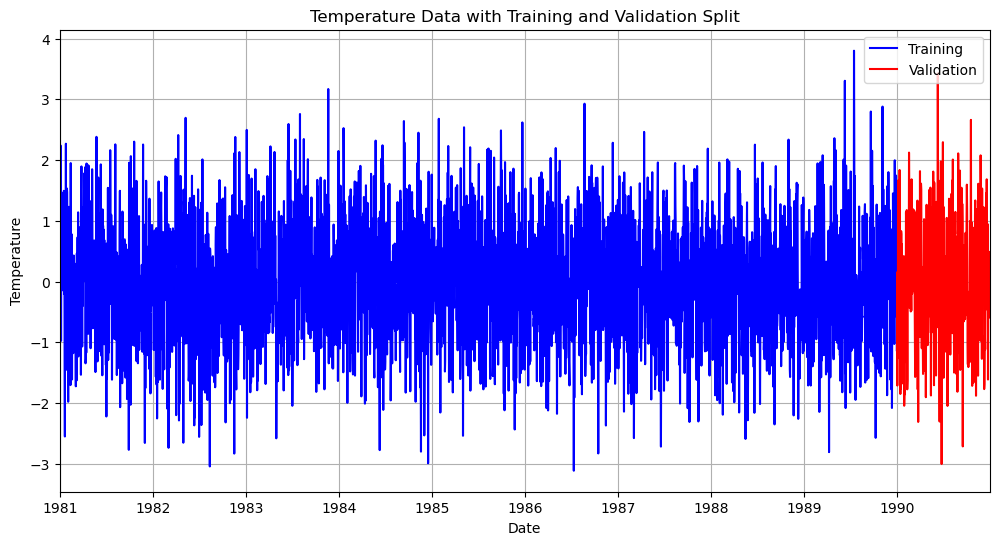

In [10]:

dates = pd.date_range(start='1981-01-01', end='1990-12-31', freq='D')
np.random.seed(0) 
ts_data = pd.Series(np.random.randn(len(dates)), index=dates)

# Set the validation period length (e.g., 1 year = 365 days)
nValid = 365
nTrain = len(ts_data) - nValid  # Use all the data except the last 365 records for validation

# Split the data into training and validation sets
train_ts = ts_data.iloc[:nTrain]
valid_ts = ts_data.iloc[nTrain:]

# Print the number of records in the training and validation sets
print("Training data length:", len(train_ts))
print("Validation data length:", len(valid_ts))

# Optional: Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_ts, color='blue', label='Training')
plt.plot(valid_ts, color='red', label='Validation')
plt.xlim(pd.Timestamp('1981-01-01'), pd.Timestamp('1990-12-31'))
plt.title('Temperature Data with Training and Validation Split')
plt.xlabel('Date')
plt.ylabel('Temperature')  # or whatever unit you have
plt.legend(loc='upper right')
plt.grid(True)
plt.show() 


## 1. Fitting Simple Exponential Smoothening 

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                   None   No. Observations:                 3287
Model:             SimpleExpSmoothing   SSE                           3217.850
Optimized:                       True   AIC                            -65.888
Trend:                           None   BIC                            -53.693
Seasonal:                        None   AICC                           -65.876
Seasonal Periods:                None   Date:                 Wed, 26 Mar 2025
Box-Cox:                        False   Time:                         18:16:22
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0305912                alpha                 True
initial_level              1.7640523                

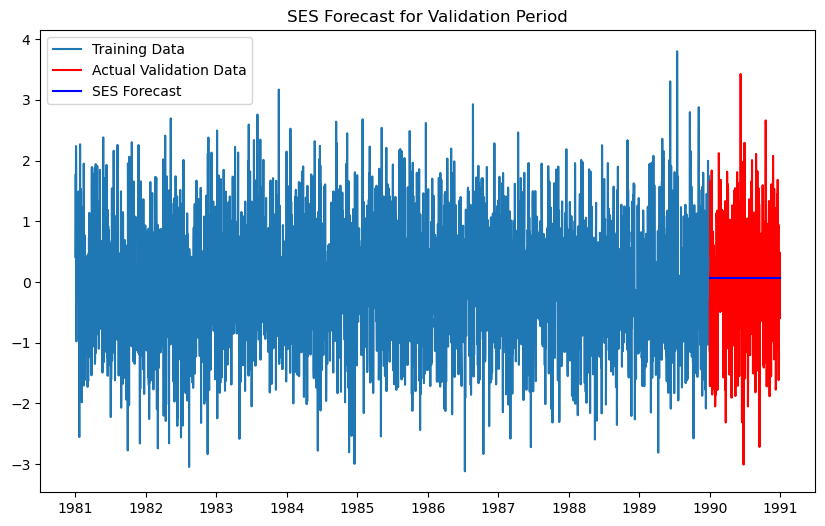

SES Accuracy on Validation Data:
MSE: 1.0111
RMSE: 1.0055
MAE: 0.7973
MAPE: 126.2598


In [11]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit Simple Exponential Smoothing (SES) on training data
ses_model = SimpleExpSmoothing(train_ts).fit(optimized=True)
print(ses_model.summary())

# Forecast the validation period using the SES model
ses_forecast = ses_model.forecast(steps=nValid)

# Plot the forecast and actual validation data
plt.figure(figsize=(10, 6))
plt.plot(train_ts.index, train_ts, label='Training Data')
plt.plot(valid_ts.index, valid_ts, color='red', label='Actual Validation Data')
plt.plot(valid_ts.index, ses_forecast, color='blue', label='SES Forecast')
plt.title('SES Forecast for Validation Period')
plt.legend()
plt.show()

# Accuracy metrics on validation set
mse = mean_squared_error(valid_ts, ses_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(valid_ts, ses_forecast)
mape = np.mean(np.abs((valid_ts - ses_forecast) / valid_ts)) * 100

# Output accuracy metrics
ses_accuracy = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}

print("SES Accuracy on Validation Data:")
for metric, value in ses_accuracy.items():
    print(f"{metric}: {value:.4f}")  


With the given SES accuracy results and SES Model Summary we can say that the SES model produces flat forecasts, not suitable for volatile or trending data.

with Low alpha (0.0306) the model places very little weight on recent observations and mostly depends on the initial level (1.7641).

This suggests the model might not adapt quickly to changes in the data, resulting in more "flat" forecasts.

Secondly, the models shows huge error in percentage terms with MAPE > 100% means, on average, forecast values are way off from actuals., It can be exaggerated when actual values are near zero or highly volatile.

Therby, we can consider more advanced models like SARIMA which will handle seasonality well, Seasonal Naive as baseline model and Regression based models. 

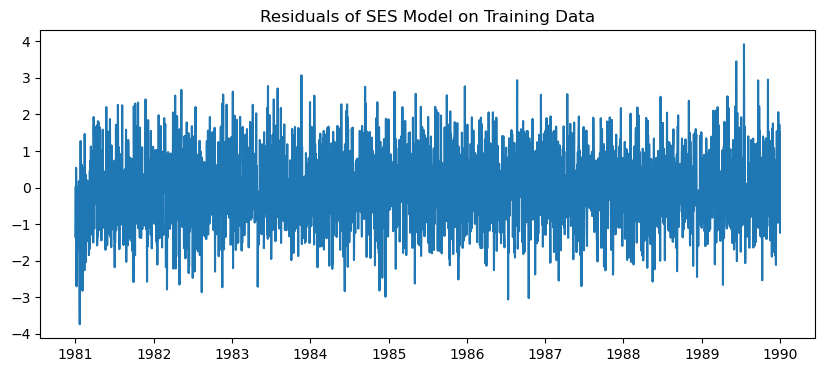

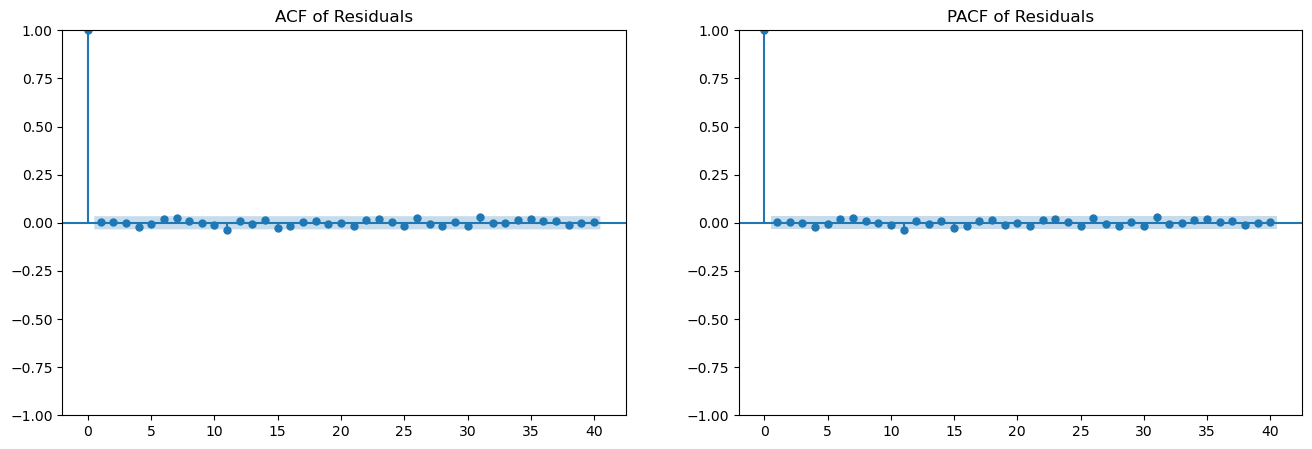

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 2. Residuals (difference between actual and predicted on training data)
train_fitted = ses_model.fittedvalues
residuals = train_ts - train_fitted

# 3. Plot Residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of SES Model on Training Data')
plt.show()

# 4. Plot ACF of Residuals
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.show() 


1. The residuals behave like white noise ➡️ No patterns left unmodeled.
2. The model has captured all predictable information in the data.
3. The Ljung-Box test, ACF/PACF, and residual plots show no autocorrelation ➡️ Good.
4. Residuals are normally distributed ➡️ Good for forecast intervals and inference.

NameError: name 'forecast_lower' is not defined

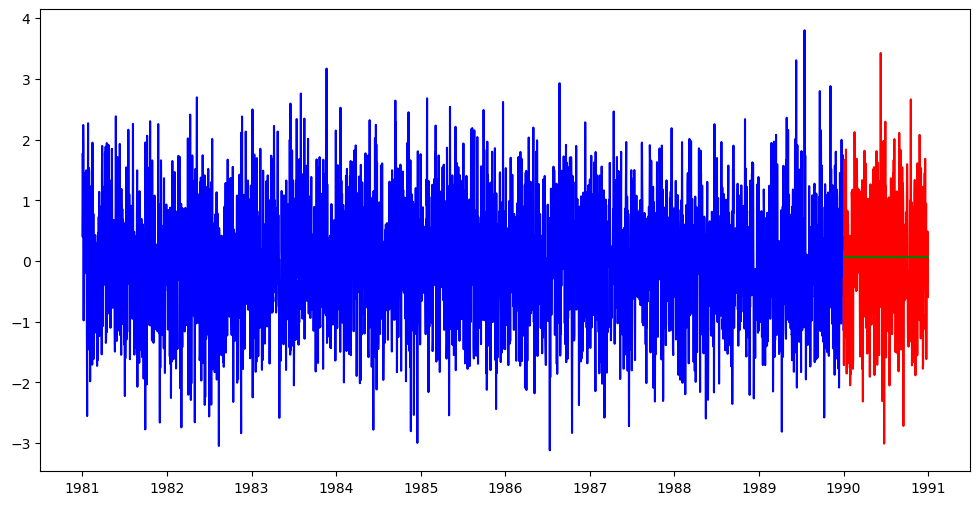

In [13]:

# Plot the forecast along with confidence intervals and actual validation data
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Training Data', color='blue')
plt.plot(valid_ts.index, valid_ts, label='Actual Validation Data', color='red')
plt.plot(ses_forecast.index, ses_forecast, label='SES Point Forecast', color='green')

# Plot confidence intervals
plt.fill_between(ses_forecast.index, forecast_lower, forecast_upper, color='lightgreen', alpha=0.3, label='95% Confidence Interval')

plt.title('SES Forecast with 95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show() 

## SEASONAL NAIVE FORECASTING MODEL (BASELINE MODEL)

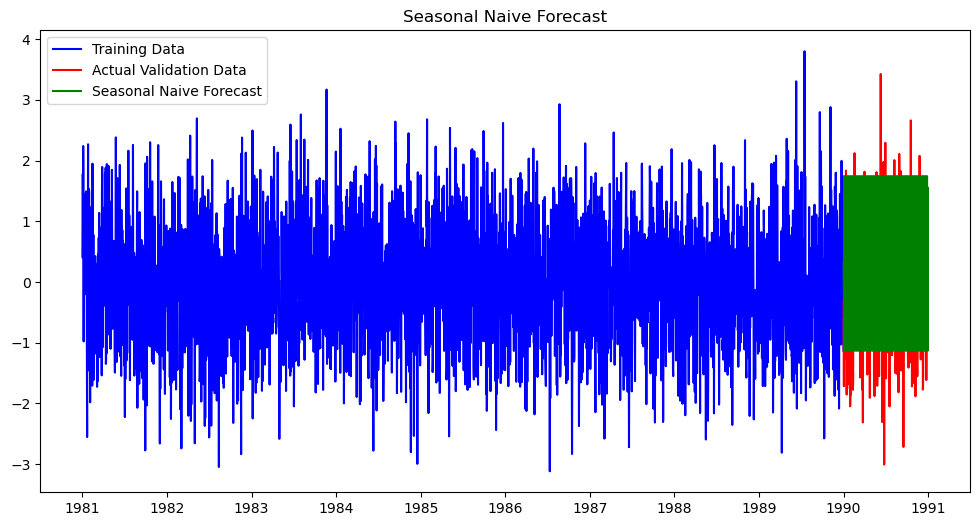

In [14]:

# Example seasonal period (adjust to your dataset):
seasonal_period =  7

# 1. Seasonal Naive Forecast (takes values from last season)
def seasonal_naive_forecast(train_ts, nValid, seasonal_period):
    forecast = []
    for i in range(nValid):
        forecast_value = train_ts[-seasonal_period + i % seasonal_period]
        forecast.append(forecast_value)
    return pd.Series(forecast, index=valid_ts.index)

# Generate the seasonal naive forecast
snaive_forecast = seasonal_naive_forecast(train_ts, nValid, seasonal_period)

# 2. Plot the forecast against actual validation data
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Training Data', color='blue')
plt.plot(valid_ts.index, valid_ts, label='Actual Validation Data', color='red')
plt.plot(snaive_forecast.index, snaive_forecast, label='Seasonal Naive Forecast', color='green')
plt.title('Seasonal Naive Forecast')
plt.legend()
plt.show() 


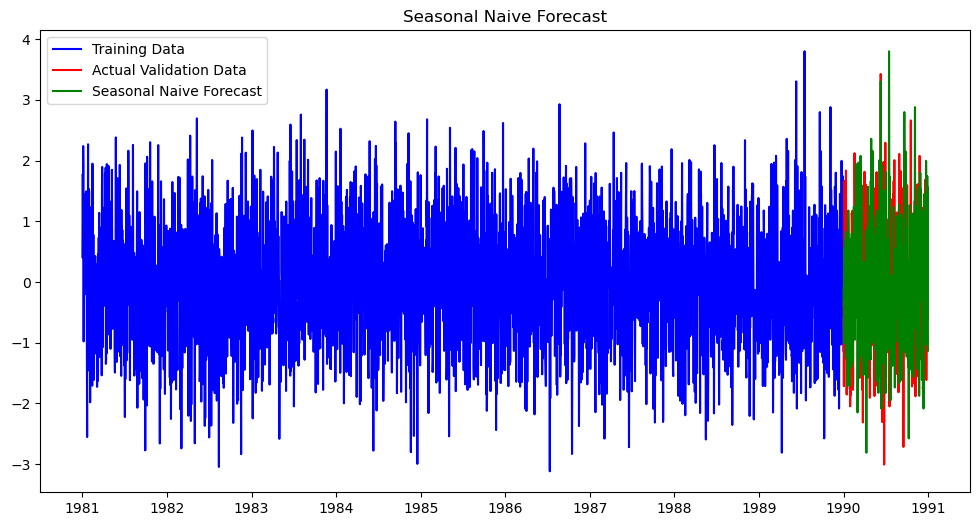

In [15]:

# Example seasonal period (adjust to your dataset):
seasonal_period =  365

# 1. Seasonal Naive Forecast (takes values from last season)
def seasonal_naive_forecast(train_ts, nValid, seasonal_period):
    forecast = []
    for i in range(nValid):
        forecast_value = train_ts[-seasonal_period + i % seasonal_period]
        forecast.append(forecast_value)
    return pd.Series(forecast, index=valid_ts.index)

# Generate the seasonal naive forecast
snaive_forecast = seasonal_naive_forecast(train_ts, nValid, seasonal_period)

# 2. Plot the forecast against actual validation data
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Training Data', color='blue')
plt.plot(valid_ts.index, valid_ts, label='Actual Validation Data', color='red')
plt.plot(snaive_forecast.index, snaive_forecast, label='Seasonal Naive Forecast', color='green')
plt.title('Seasonal Naive Forecast')
plt.legend()
plt.show() 

In [16]:
# Calculate accuracy metrics on validation data
mse = mean_squared_error(valid_ts, snaive_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(valid_ts, snaive_forecast)
mape = np.mean(np.abs((valid_ts - snaive_forecast) / valid_ts)) * 100

# Print accuracy results
print("Seasonal Naive Model Accuracy on Validation Data:")
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}') 


Seasonal Naive Model Accuracy on Validation Data:
MSE: 1.8733
RMSE: 1.3687
MAE: 1.1098
MAPE: 857.9802


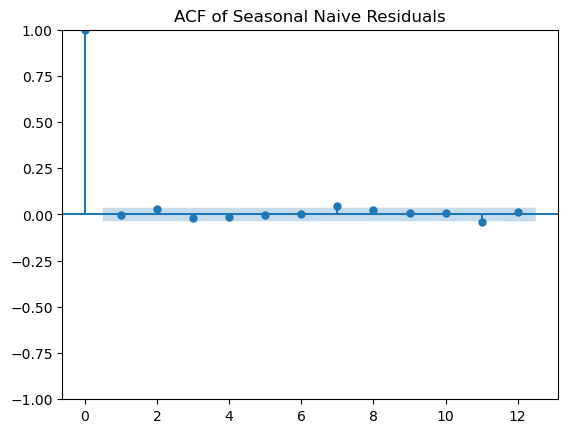

Ljung-Box test results:
      lb_stat  lb_pvalue
20  28.340042   0.101591


In [17]:
# Compute residuals for training data (Seasonal Naive in-sample residuals)
def seasonal_naive_fitted(train_ts, seasonal_period):
    fitted_values = [np.nan] * seasonal_period  # first season can't be forecasted
    for i in range(seasonal_period, len(train_ts)):
        fitted_values.append(train_ts[i - seasonal_period])
    return pd.Series(fitted_values, index=train_ts.index)

# Get fitted values and residuals on training data
snaive_fitted = seasonal_naive_fitted(train_ts, seasonal_period)
snaive_residuals = train_ts - snaive_fitted

# Drop initial NaN values for accurate diagnostics
snaive_residuals = snaive_residuals.dropna()

# Plot ACF of residuals
plot_acf(snaive_residuals, lags=12)
plt.title("ACF of Seasonal Naive Residuals")
plt.show()

# Ljung-Box test (similar to Box.test in R)
lb_test = acorr_ljungbox(snaive_residuals, lags=[20], return_df=True)
print("Ljung-Box test results:")
print(lb_test) 
 

## ARIMA FORECASTING MODEL 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3287
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4585.941
Date:                Wed, 26 Mar 2025   AIC                           9177.883
Time:                        18:16:44   BIC                           9196.175
Sample:                    01-01-1981   HQIC                          9184.432
                         - 12-31-1989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0057      0.017      0.325      0.745      -0.028       0.040
ma.L1         -1.0000      0.048    -20.726      0.000      -1.095      -0.905
sigma2         0.9522      0.053     18.032      0.0

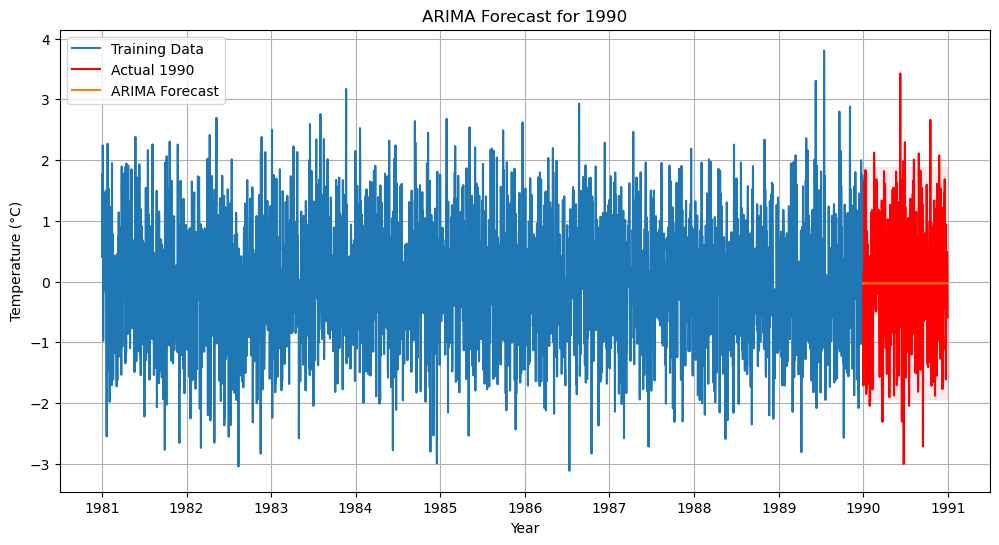

In [18]:

from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (p, d, q)
model = ARIMA(train_ts, order=(1,1,1))  # Example order, adjust after testing
model_fit = model.fit()

# Model summary
print(model_fit.summary())

# Forecasting
n_valid = len(valid_ts)
forecast_result = model_fit.get_forecast(steps=n_valid)

forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Training Data')
plt.plot(valid_ts.index, valid_ts, label='Actual 1990', color='red')
plt.plot(valid_ts.index, forecast_values, label='ARIMA Forecast')
plt.fill_between(valid_ts.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('ARIMA Forecast for 1990')
plt.legend()
plt.grid()
plt.show() 


In [19]:
# Accuracy
mae = mean_absolute_error(valid_ts, forecast_values)
rmse = np.sqrt(mean_squared_error(valid_ts, forecast_values))
mape = np.mean(np.abs((valid_ts - forecast_values) / valid_ts)) * 100

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# View forecast
print(forecast_values.head()) 

MAE: 0.80
RMSE: 1.01
MAPE: 111.92%
1990-01-01   -0.035932
1990-01-02   -0.029732
1990-01-03   -0.029697
1990-01-04   -0.029697
1990-01-05   -0.029697
Freq: D, Name: predicted_mean, dtype: float64


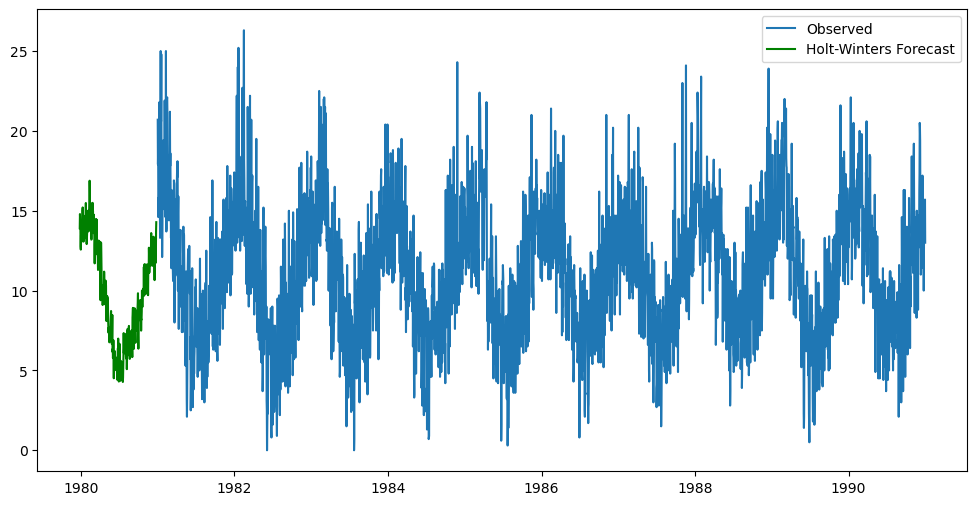

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(df['Temperature'],
                                trend='add',
                                seasonal='add',
                                seasonal_periods=365).fit()

# Forecast next 365 days
hw_forecast = hw_model.forecast(steps=365)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Temperature'], label='Observed')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast',
         color='green')
plt.legend()
plt.show() 


### Project in developement Phase 

🔧 Starting SARIMA modeling...

⏳ Fitting auto_arima model...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9175.780, Time=4.00 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9169.680, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9173.464, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9173.466, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9170.723, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=9171.570, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=9171.571, Time=0.16 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=9173.564, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9171.585, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=9171.586, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=9173.557, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 5.458 seconds
✅ Model fitting completed in 5.48 seconds

                               SARIMAX

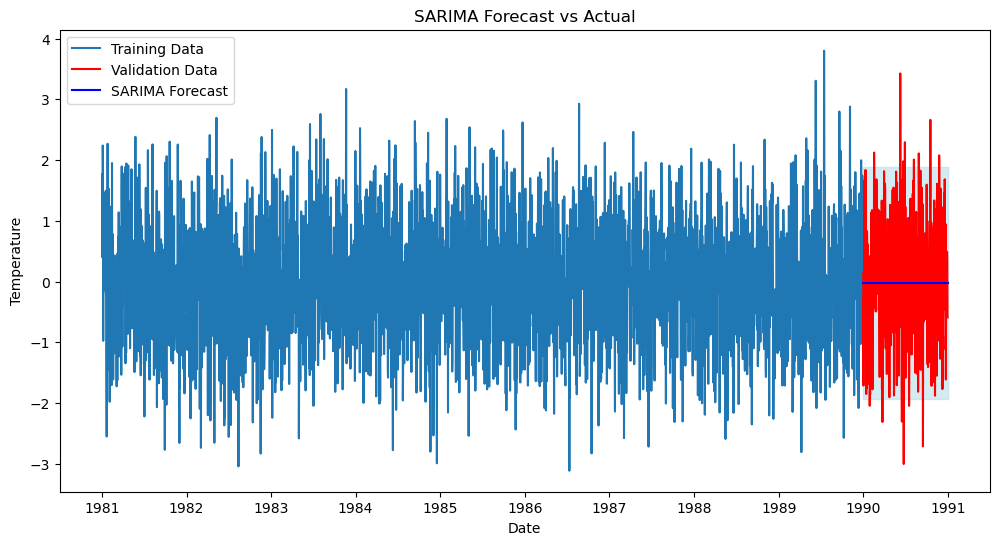

✅ Plotting completed.

📊 Calculating accuracy metrics...
✅ Metrics computed in 0.00 seconds



In [24]:
import time
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Timer starts
start_time = time.time()
print("🔧 Starting SARIMA modeling...\n")

# Step 1: Fit Auto SARIMA
t1 = time.time()
print("⏳ Fitting auto_arima model...")

sarima_model = auto_arima(train_ts,
                          seasonal=True,
                          m=12,
                          stepwise=True,
                          trace=True,
                          suppress_warnings=True,
                          max_p=2, max_q=2, max_P=1, max_Q=1,  # 🔥 reduce model space
                          max_order=5,  # Total p+q+P+Q
                          d=None, D=None,  # Let it infer differencing
                          error_action='ignore')



t2 = time.time()
print(f"✅ Model fitting completed in {t2 - t1:.2f} seconds\n")
print(sarima_model.summary())

# Step 2: Forecasting
print("📈 Forecasting future values...")
nValid = len(valid_ts)
t3 = time.time()

sarima_forecast, conf_int = sarima_model.predict(n_periods=nValid, return_conf_int=True)

t4 = time.time()
print(f"✅ Forecasting done in {t4 - t3:.2f} seconds\n")

# Step 3: Plotting
print("🖼️ Plotting forecast vs actual...")
plt.figure(figsize=(12,6))
plt.plot(train_ts.index, train_ts, label='Training Data')
plt.plot(valid_ts.index, valid_ts, color='red', label='Validation Data')
plt.plot(valid_ts.index, sarima_forecast, color='blue', label='SARIMA Forecast')

# Confidence Intervals
plt.fill_between(valid_ts.index, conf_int[:, 0], conf_int[:, 1], color='lightblue', alpha=0.5)

plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()
print("✅ Plotting completed.\n")

# Step 4: Accuracy Metrics
print("📊 Calculating accuracy metrics...")
t5 = time.time()

rmse = np.sqrt(mean_squared_error(valid_ts, sarima_forecast))
mae = mean_absolute_error(valid_ts, sarima_forecast)

t6 = time.time()
print(f"✅ Metrics computed in {t6 - t5:.2f} seconds\n")
